# 接口设计简介

参考：[oo-design](https://d2l.ai/chapter_linear-regression/oo-design.html)

> (i) Module contains models, losses, and optimization methods; (ii) DataModule provides data loaders for training and validation; (iii) both classes are combined using the Trainer class, which allows us to train models on a variety of hardware platforms. Most code in this book adapts Module and DataModule. We will touch upon the Trainer class only when we discuss GPUs, CPUs, parallel training, and optimization algorithms.

In [1]:
import time
import numpy as np
import torch
from torch import nn

## 实用程序

需要一些实用程序来简化 Jupyter Notebook 中的面向对象编程。

第一个实用函数 {func}`~torch_book.add_to_class` 允许在创建类之后将函数注册为类中的方法。事实上，即使已经创建了类的实例，也可以这样做！它允许将类的实现拆分为多个代码块。

In [2]:
def add_to_class(Class):
    def wrapper(obj):
        setattr(Class, obj.__name__, obj)
    return wrapper

比如计划实现类 `A` 的方法 `do`。可以先声明类 `A` 并创建实例 `a`，而不是在同一个代码块中同时拥有 `A`和 `do` 的代码。

In [3]:
class A:
    def __init__(self):
        self.b = 1

a = A()

接下来，按照通常的方式定义方法 `do`，但不在类 `A` 的范围内。相反，我们用 `add_to_class` 修饰这个方法，用类 `A` 作为它的参数。在这样做的过程中，该方法能够访问 `A` 的成员变量，就像期望的那样，如果它被定义为 `A` 定义的一部分。

In [4]:
@add_to_class(A)
def do(self):
    print('类属性 "b" 是', self.b)
a.do()

类属性 "b" 是 1


第二个是实用类，它将类的 `__init__` 方法中的所有参数保存为类属性。这允许隐式扩展构造函数调用签名，而不需要额外的代码。

In [5]:
import inspect

class HyperParameters:
    def save_hyperparameters(self, ignore=[]):
        """Save function arguments into class attributes."""
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

要使用它，需要定义从 `HyperParameters` 继承的类，并在 `__init__` 方法中调用 {meth}`~HyperParameters.save_hyperparameters`。

In [7]:
class B(HyperParameters):
    def __init__(self, a, b, c):
        self.save_hyperparameters(ignore=['c'])
        print('self.a =', self.a, 'self.b =', self.b)
        print('这里不存在 self.c =', not hasattr(self, 'c'))

b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
这里不存在 self.c = True


最后一个实用程序允许在实验进行时交互式地绘制实验进展。

In [8]:
from torch_book.plotx import ProgressBoard

{func}`draw` 函数在图中绘制点 `(x, y)`，并在图例中指定标签。可选的 `every_n` 通过仅显示图中 $1/n$ 的点来平滑直线。它们的值是从原始图中的相邻 $n$ 点取平均值。

在下面的例子中，用不同的平滑度画 `sin` 和 `cos`。如果运行此代码块，您将看到这些行在动画中增长。

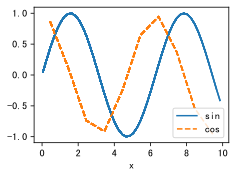

In [9]:
board = ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10)

## 模型

{class}`~torch_book.model.Module` 类是将实现的所有模型的基类。至少需要定义三个方法。`__init__` 方法存储可学习参数，`training_step` 方法接受数据批处理以返回 loss 值，`configure_optimators` 方法返回优化方法或它们的列表，用于更新可学习参数。可以选择定义 `validation_step` 来报告评估度量。有时将计算输出的代码放入单独的 `forward` 方法中，以使其更易于重用。

您可能会注意到 `Module` 是 {class}`torch.nn.Module` 的子类，PyTorch 中神经网络的基类。它提供了处理神经网络的方便特性。例如，如果定义 `forward` 方法，例如 `forward(self, X)`，那么对于实例 `a`，可以通过 `a(X)` 调用这个函数。这是因为它调用了内置 `__call__` 方法中的 `forward` 方法。

## 数据

{class}`~torch_book.loader.DataModule` 类是数据的基类。通常使用 `__init__` 方法来准备数据。如果需要，这包括下载和预处理。`train_dataloader` 返回训练数据集的数据加载器。数据加载器是 Python 生成器，它在每次使用时产生数据 batch。然后将此 batch 输入 `Module` 的 `training_step` 方法，以计算 `loss`。有可选的 `val_dataloader` 用于返回验证数据集加载器。它的行为方式与此相同，不同的是它为 `Module` 中的 `validation_step` 方法生成数据 batch。

## 训练

`{class}`~torch_book.optim.Trainer` 类使用 {class}`~torch_book.loader.DataModule` 中指定的数据来训练 {class}`~torch_book.model.Module` 类中的可学习参数。

关键方法是 `fit`，它接受两个参数：`model` （{class}`~torch_book.model.Module` 的实例）和 `data` （{class}`~torch_book.loader.DataModule` 的实例）。然后遍历整个数据集 `max_epochs` 次数来训练模型。